# Chapter 10 - Deep Learning for Time Series

In [5]:
import pandas as pd


%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's model airplane passengers. We'll forecast the monthly number of passengers.
This dataset is considered one of the classic time-series, published by George E.P.
Box and Gwilym Jenkins alongside the book "Time-Series Analysis: Forecasting and
Control" (1976).

In [5]:
url_airline_passengers = "https://raw.githubusercontent.com/benman1/Machine-Learning-for-Time-Series-with-Python/main/chapter10/passengers.csv"


def get_passengers():
    df = pd.read_csv(url_airline_passengers, parse_dates=["date"]).set_index("date")
    return df


passengers = get_passengers()
passengers.head()

,passengers
date,
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0


<AxesSubplot:xlabel='date'>

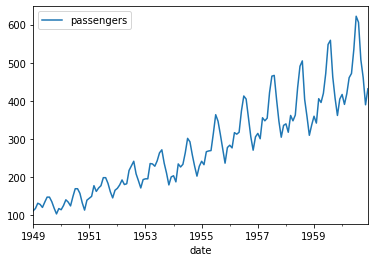

In [7]:
passengers.plot()

We'll first start with a simple FCN and then we'll apply a recurrent network, and
finally, we'll apply a very recent architecture, a Dilated Causal Convolutional Neural
Network.
The FCN is first.

# Fully connected network
In this first practice session, we'll use TensorFlow libraries, which we can quickly
install from the terminal (or similarly from the anaconda navigator):

Let's try naively to just use an FCN, also known as an MLP.
Let's set some imports and set a couple of global constants:

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout

In [17]:
DROPOUT_RATIO = 0.2  # Dropout ratio typically between 0.2 and 0.5
HIDDEN_NEURONS = 100

callback = keras.callbacks.EarlyStopping(
    monitor="loss", patience=3
)  # patience = number of epochs to wait if no change in loss

We will use these constants for our model architecture.

*Dropout (or: Dilution)* is a regularization technique that can help reducing
overfitting. Dropout means that during training, a fraction of the connections (in
our case 20%) is randomly removed.
Early stopping is another form of regularization, where the training stops as defined
by certain conditions. In our case, we've stated it should stop if our loss doesn't
improve three times in a row. If the model stops improving, there's no point in
continuing to train it, although we may be trapped in a local minimum of the error
that we might be able to escape. One of the big advantages of early stopping is that
it can help us quickly see whether a model is working.  


We can define our model in this function:

In [10]:
def create_model(passengers):
    """Create a model to predict the number of passengers on a monthly basis."""
    input_layer = Input(len(passengers.columns))

    hiden_layer = Dropout(DROPOUT_RATIO)(input_layer)
    hiden_layer = Dense(HIDDEN_NEURONS, activation="relu")(hiden_layer)

    output_layer = Dropout(DROPOUT_RATIO)(hiden_layer)
    output_layer = Dense(1)(output_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(),
        metrics=[
            keras.metrics.RootMeanSquaredError(),
            keras.metrics.MeanAbsoluteError(),
        ],
    )
    return model

With the Keras functional API, we've defined a two-layer neural network, where
the hidden layer of HIDDEN_NEURONS neurons is activated by the Rectified Linear Unit
(ReLU) function.  
Let's split our dataset into training and test sets. We will predict the number of
passengers based on passengers in the previous time period (previous month):

In [14]:
passengers = get_passengers()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    passengers, passengers.passengers.shift(-1), shuffle=False
)

In [15]:
import numpy as np

np.shape(X_train), np.shape(X_test)

((108, 1), (36, 1))

We'll learn based on the first 75% of the dataset – this is the default value for the
test_size parameter in the train_test_split function.

We can now train our naïve FCN:

In [16]:
model = create_model(X_train)
model.fit(X_train, y_train, epochs=1000, callbacks=[callback])
predicted = model.predict(X_test)

Epoch 1/1000


2022-07-25 11:43:20.605490: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 0s 894us/step - loss: 93990.1406 - root_mean_squared_error: 306.5781 - mean_absolute_error: 284.8212
Epoch 2/1000
4/4 [==============================] - 0s 637us/step - loss: 82402.0703 - root_mean_squared_error: 287.0576 - mean_absolute_error: 268.2788
Epoch 3/1000
4/4 [==============================] - 0s 762us/step - loss: 76502.2344 - root_mean_squared_error: 276.5904 - mean_absolute_error: 258.1934
Epoch 4/1000
4/4 [==============================] - 0s 606us/step - loss: 67255.5078 - root_mean_squared_error: 259.3367 - mean_absolute_error: 241.7652
Epoch 5/1000
4/4 [==============================] - 0s 618us/step - loss: 61826.9062 - root_mean_squared_error: 248.6502 - mean_absolute_error: 231.3828
Epoch 6/1000
4/4 [==============================] - 0s 635us/step - loss: 53518.0703 - root_mean_squared_error: 231.3397 - mean_absolute_error: 215.9010
Epoch 7/1000
4/4 [==============================] - 0s 574us/step - loss: 48933.1250 - root_mea

Ideally, we would see the error (loss) going down, and we'd see a low error at the
end. I haven't included any code to fix the random number generator (tf.random.
set_seed), so your output might differ.  
We can then get the predictions for the test set like this:

Now, it would be good to visualize passenger predictions against the actual
passenger values.
We can use this function:

In [27]:
import matplotlib.pyplot as plt


def show_result(y_test, predicted, ylabel="Passengers"):
    """Plot the test data and the predicted values."""
    plt.figure(figsize=(16, 6))
    plt.plot(y_test.index, predicted, "o-", label="predicted")
    plt.plot(y_test.index, y_test, ".-", label="actual")
    plt.ylabel(ylabel)
    plt.legend()

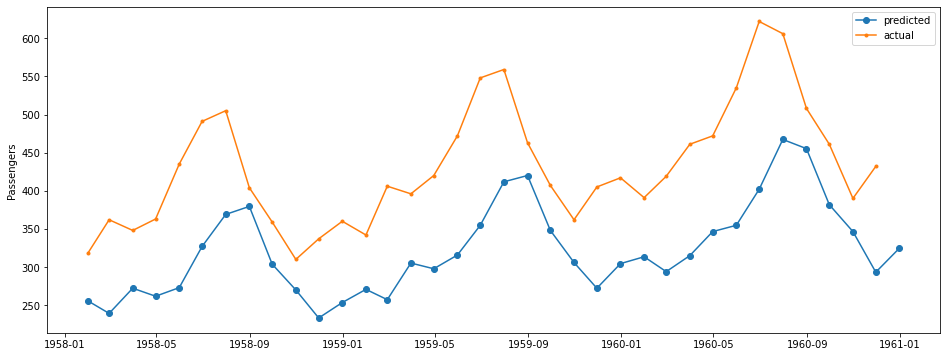

In [18]:
show_result(y_test, predicted)

this is systematically under-predicting – it has learned the baseline from the years 1949-
1958 of the training set, when far fewer passengers were traveling.
Let's make this a bit more sophisticated and better.  

This first model was trained only on the immediate previous number of travelers.
As a first step, we'll include the year and the month as predictor variables. The
year can be used to model the trend, while the month is coupled to the monthly
variability – so this seems a natural step.  

This will add month and year columns to the DataFrame based on the
`DateTimeIndex:`

In [20]:
# passengers["year"] = passengers.index.year.values - passengers.index.year.values.min()
# passengers["month"] = passengers.index.month.values - 1

passengers["month"] = passengers.index.month.values
passengers["year"] = passengers.index.year.values

passengers.head()

,passengers,month,year
date,,,
1949-01-31,112.0,1,1949
1949-02-28,118.0,2,1949
1949-03-31,132.0,3,1949
1949-04-30,129.0,4,1949
1949-05-31,121.0,5,1949


In [21]:
# Now another round of training

X_train, X_test, y_train, y_test = train_test_split(
    passengers, passengers.passengers.shift(-1), shuffle=False
)

np.shape(X_train), np.shape(X_test)

((108, 3), (36, 3))

In [22]:
# redefine model - add more inputs


model = create_model(X_train)

Epoch 1/100
4/4 [==============================] - 0s 772us/step - loss: 128211.3984 - root_mean_squared_error: 358.0662 - mean_absolute_error: 321.3853
Epoch 2/100
4/4 [==============================] - 0s 600us/step - loss: 59991.6562 - root_mean_squared_error: 244.9319 - mean_absolute_error: 196.5806
Epoch 3/100
4/4 [==============================] - 0s 850us/step - loss: 45994.3984 - root_mean_squared_error: 214.4630 - mean_absolute_error: 178.4279
Epoch 4/100
4/4 [==============================] - 0s 896us/step - loss: 45888.6602 - root_mean_squared_error: 214.2164 - mean_absolute_error: 176.3470
Epoch 5/100
4/4 [==============================] - 0s 969us/step - loss: 45076.2031 - root_mean_squared_error: 212.3116 - mean_absolute_error: 175.3883
Epoch 6/100
4/4 [==============================] - 0s 692us/step - loss: 44212.8047 - root_mean_squared_error: 210.2684 - mean_absolute_error: 183.4486
Epoch 7/100
4/4 [==============================] - 0s 838us/step - loss: 45662.0469 - r

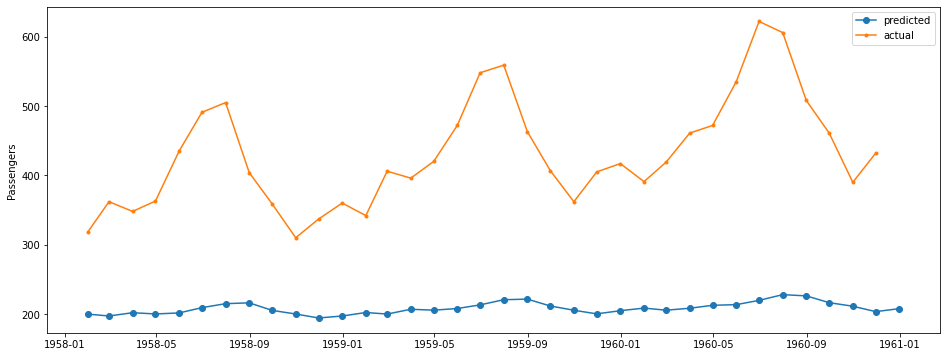

In [23]:
model.fit(X_train, y_train, epochs=100, callbacks=[callback])
predicted = model.predict(X_test)
show_result(y_test, predicted)

Please note that, because of the high number of parameters, and the randomness
involved in the learning process, the outcome might differ significantly between
runs. This is indeed one of the problems associated with deep learning.  

This already looks much better. The year feature helped our model learn the
baseline. The model has learned something about the monthly variability, but it's not
enough to really approximate it.   

Let's create a less naïve version. We will change a few things in this model:  

• We'll add an embedding of the month feature
• We'll treat the year as a linear predictor
• We'll add the previous month's passengers to our predictions
• Finally, we'll scale our predictions based on the standard deviation in the
training dataset  

That was quite a mouthful. Let's go through these a bit more slowly.  

We fed the months as values from 1 to 12 into our previous model. However, we
could intuitively guess that January (1) and December (12) are perhaps more similar
than November (11) and December. We know that there are lots of travelers in both
December and January, but perhaps a much lower volume in November. We can
capture these relationships based on the data.  

This can be done in an embedding layer. An embedding layer is a mapping of
distinct categories to real numbers. This mapping is updated as part of the network
optimization.  

The year is closely related to the overall trend. Each year, the number of airline
passengers increases. We can model this relationship non-linearly or linearly. Here,
I've decided to just model a linear relationship between the year feature and the
outcome.  

The relationship between the previous month's passenger numbers and those in this
month is again assumed to be linear.  

Finally, we can scale our predictions, similar to the inverse transformation of the
standard transformation. You should remember the standard normalization from `Chap 3`

## FFN with embedding

We'll need a few more imports first:

In [24]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Input
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

Now, we redefine our network as follows:

In [25]:
def create_model(train):
    """Create a model to predict the number of passengers on a monthly basis.
    With the use of an embedding layer and a dense layer."""
    scale = tf.constant(train.passengers.std())
    scale = tf.cast(scale, tf.float32)
    continuous_layer = Input(shape=1)

    categorical_months_layer = Input(shape=1)
    embedded_months = Embedding(12, 5)(categorical_months_layer)
    embedded_flat_months = Flatten()(embedded_months)

    year_input = Input(shape=1)
    year_layer = Dense(1)(year_input)

    hidden_output = Concatenate(-1)(
        [embedded_flat_months, year_layer, continuous_layer]
    )
    output_layer = Dense(1)(hidden_output)
    output = output_layer * scale + continuous_layer

    model = keras.models.Model(
        inputs=[continuous_layer, categorical_months_layer, year_input],
        outputs=output,
    )
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(),
        metrics=[RootMeanSquaredError(), MeanAbsoluteError()],
    )
    return model

We reinitialise our model

In [26]:
passengers = get_passengers()
passengers["year"] = passengers.index.year.values - passengers.index.year.values.min()
passengers["month"] = passengers.index.month.values - 1
passengers.head()

,passengers,year,month
date,,,
1949-01-31,112.0,0,0
1949-02-28,118.0,0,1
1949-03-31,132.0,0,2
1949-04-30,129.0,0,3
1949-05-31,121.0,0,4


During training and for prediction purposes, we need to feed the three types of input
separately like this:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    passengers, passengers.passengers.shift(-1), shuffle=False
)

In [28]:
X_train.dtypes

passengers    float64
year            int64
month           int64
dtype: object

In [29]:
model = create_model(X_train)

model.fit(
    (X_train["passengers"], X_train["month"], X_train["year"]),
    y_train,
    epochs=1000,
    callbacks=[callback],
)
predicted = model.predict((X_test["passengers"], X_test["month"], X_test["year"]))

Epoch 1/1000
4/4 [==============================] - 0s 926us/step - loss: 3084913.2500 - root_mean_squared_error: 1756.3921 - mean_absolute_error: 1650.8771
Epoch 2/1000
4/4 [==============================] - 0s 875us/step - loss: 2787601.7500 - root_mean_squared_error: 1669.6112 - mean_absolute_error: 1569.7139
Epoch 3/1000
4/4 [==============================] - 0s 811us/step - loss: 2512878.7500 - root_mean_squared_error: 1585.2062 - mean_absolute_error: 1489.9966
Epoch 4/1000
4/4 [==============================] - 0s 772us/step - loss: 2249196.5000 - root_mean_squared_error: 1499.7322 - mean_absolute_error: 1410.1139
Epoch 5/1000
4/4 [==============================] - 0s 763us/step - loss: 2014434.1250 - root_mean_squared_error: 1419.3076 - mean_absolute_error: 1333.1444
Epoch 6/1000
4/4 [==============================] - 0s 802us/step - loss: 1791048.2500 - root_mean_squared_error: 1338.3005 - mean_absolute_error: 1256.8934
Epoch 7/1000
4/4 [==============================] - 0s 938

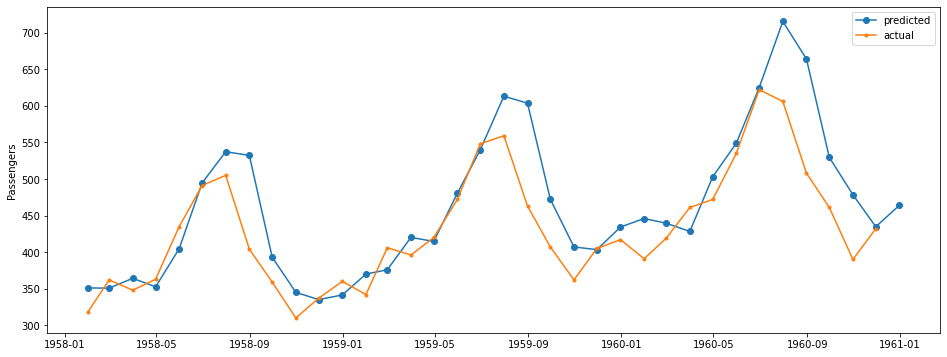

In [62]:
show_result(y_test, predicted)

# Recurrent neural network

We discussed in the theory section that recurrent neural networks can be very good
at modeling long-term relationships between points in a time-series. Let's set up an
RNN.  

We'll use the same dataset as before – the univariate values of airline passengers. In
this case, our network is going to need a sequence of points for each training sample.
At each training step, the RNN is going to be trained on points (passengers) leading
up to the next passenger number.  

Please note that we can use TensorFlow (or even statsmodels' lagmat()) utility
functions for this purpose (and we will use them in Chapter 12, Case Studies), but in
this instance, we'll write this quickly ourselves.  

We'll need to resample our passenger numbers thus:

In [46]:
def wrap_data(df, lookback: int):
    """Wrap the data into a format that is compatible with the LSTM model."""
    dataset = []
    for index in range(lookback, len(df) + 1):
        features = {
            f"col_{i}": float(val)
            for i, val in enumerate(df.iloc[index - lookback : index].values)
        }
        row = pd.DataFrame.from_dict([features])
        row.index = [df.index[index - 1]]
        dataset.append(row)
    return pd.concat(dataset, axis=0)

This function does the job. It goes over all the points in the dataset and takes a
sequence leading up to it. The number of points in the new sequence is defined by
the parameter lookback.  

Let's put it to use:

A “lookback period” defines how many previous timesteps are used in order to predict the subsequent timestep.

The lookback period is set to 4 in this instance. This means that we are using the time steps at t-3, t-2, t-1, and t to predict the value at time t+1.

In [112]:
LOOKBACK = 4
passengers = get_passengers()
dataset = wrap_data(passengers, lookback=LOOKBACK)
dataset = dataset.join(passengers.shift(-1))

dataset.head()

,col_0,col_1,col_2,col_3,passengers
1949-04-30,112.0,118.0,132.0,129.0,121.0
1949-05-31,118.0,132.0,129.0,121.0,135.0
1949-06-30,132.0,129.0,121.0,135.0,148.0
1949-07-31,129.0,121.0,135.0,148.0,148.0
1949-08-31,121.0,135.0,148.0,148.0,136.0


In [113]:
dataset.isna().sum()

col_0         0
col_1         0
col_2         0
col_3         0
passengers    1
dtype: int64

We are using a lookback of 10. I've deliberately chosen a value that is not optimal.
I'm leaving it as an exercise to the reader to choose one that's better and try it out.  

The last line in the code above joins the targets (lookahead 1) together with the
sequences.  

We are ready to define our network, but let's get the imports out of the way:

In [114]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
import tensorflow as tf

In [115]:
def create_model(passengers):
    input_layer = Input(shape=(LOOKBACK, 1))
    recurrent = Bidirectional(LSTM(100, activation=None))(input_layer)
    output_layer = Dense(1)(recurrent)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(),
        metrics=[
            keras.metrics.RootMeanSquaredError(),
            keras.metrics.MeanAbsoluteError(),
        ],
    )
    return model

It's a bidirectional LSTM network. The result of the last layer is projected linearly as
our output. I've set the activation function of the LSTM to tanh in case you want to
run this on a GPU runtime, so it will benefit from NVIDIA's GPU-accelerated library
cuDNN. We are extracting the same metrics as in the previous practice.  

A few more preliminaries that you should be familiar with from the previous section
are as follows:

In [116]:
from sklearn.model_selection import train_test_split

callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
model = create_model(passengers)
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop(columns="passengers"), dataset["passengers"], shuffle=False
)

In [117]:
model.fit(X_train, y_train, epochs=1000, callbacks=[callback])

Epoch 1/1000
4/4 [==============================] - 1s 3ms/step - loss: 73136.7656 - root_mean_squared_error: 270.4381 - mean_absolute_error: 254.4470
Epoch 2/1000
4/4 [==============================] - 0s 3ms/step - loss: 37978.4336 - root_mean_squared_error: 194.8806 - mean_absolute_error: 180.6607
Epoch 3/1000
4/4 [==============================] - 0s 3ms/step - loss: 10790.2432 - root_mean_squared_error: 103.8761 - mean_absolute_error: 90.5262
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 2294.9509 - root_mean_squared_error: 47.9056 - mean_absolute_error: 34.5664
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 2477.9028 - root_mean_squared_error: 49.7785 - mean_absolute_error: 35.4005
Epoch 6/1000
4/4 [==============================] - 0s 3ms/step - loss: 1436.1642 - root_mean_squared_error: 37.8968 - mean_absolute_error: 29.1498
Epoch 7/1000
4/4 [==============================] - 0s 3ms/step - loss: 1604.5742 - root_mean_squared_er

In [118]:
predicted = model.predict((X_test))

2/2 [==============================] - 0s 1ms/step


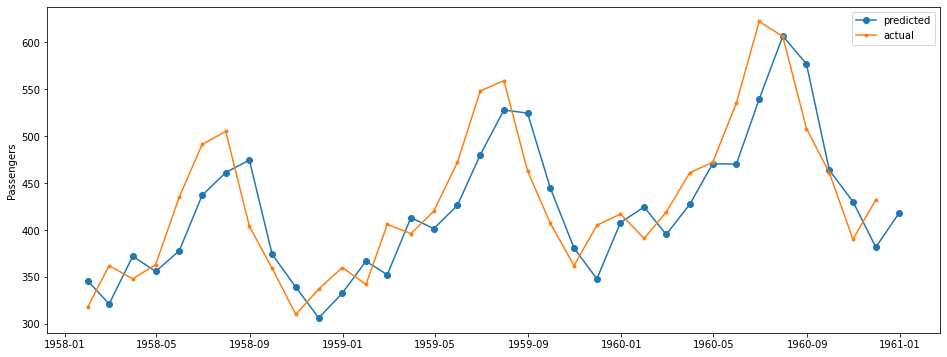

In [119]:
show_result(y_test, predicted)

# Dilated causal convolutional neural network

This example is based on Krist Papadopoulos's SeriesNet implementation of the
paper "Conditional Time-Series Forecasting with Convolutional Neural Networks," by
Anastasia Borovykh and others.  

We'll implement this model together and we'll apply it to two datasets to see how it
does out of the box. I won't be going through tweaking the data and architecture in
this example.  

First, the imports:

In [18]:
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Input, Add, Activation, Dropout
from keras.models import Sequential, Model
from keras.layers import LeakyReLU, ELU
from keras import optimizers
import tensorflow as tf

What is perhaps surprising is how easy it is to do a causal convolution in
TensorFlow. Conv1D comes with a parameter, padding, which can be specified
as 'causal'. This simply pads the layer's input with zeros according to the causal
nature, where output at time t only depends on the previous time steps, <t. Please
refer to the discussion in the ConvNets section in this chapter.  

This means that we can predict the values of early time steps in the frame.  

The main idea of this network is a residual block with causal convolutions.  
This code segment constructs the corresponding network architecture:

In [19]:
def DC_CNN_Block(nb_filter, filter_length, dilation):
    """DC CNN block.
    Dilated convolutions to reduce size of feature map
    in a learned way in place of max pooling"""

    def f(input_):
        residual = input_
        layer_out = Conv1D(
            filters=nb_filter,
            kernel_size=filter_length,
            dilation_rate=dilation, # gap between the convolutions
            activation="linear",
            padding="causal",
            use_bias=False,
        )(input_)
        layer_out = Activation("selu")(layer_out)
        skip_out = Conv1D(1, 1, activation="linear", use_bias=False)(layer_out)
        network_in = Conv1D(1, 1, activation="linear", use_bias=False)(layer_out)
        network_out = Add()([residual, network_in])
        return network_out, skip_out

    return f

I've simplified this a bit to make it easier to read.  
The network itself just stacks these layers as a SkipNet follows up with a
convolution:

In [20]:
def DC_CNN_Model(length):
    """Model for DC CNN."""
    input = Input(shape=(length, 1))
    l1a, l1b = DC_CNN_Block(32, 2, 1)(input)
    l2a, l2b = DC_CNN_Block(32, 2, 2)(l1a)
    l3a, l3b = DC_CNN_Block(32, 2, 4)(l2a)
    l4a, l4b = DC_CNN_Block(32, 2, 8)(l3a)
    l5a, l5b = DC_CNN_Block(32, 2, 16)(l4a)
    l6a, l6b = DC_CNN_Block(32, 2, 32)(l5a)
    l6b = Dropout(0.8)(l6b)
    l7a, l7b = DC_CNN_Block(32, 2, 64)(l6a)
    l7b = Dropout(0.8)(l7b)
    l8 = Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    l9 = Activation("relu")(l8)
    l21 = Conv1D(1, 1, activation="linear", use_bias=False)(l9)
    model = Model(inputs=input, outputs=l21)
    model.compile(loss="mae", optimizer=optimizers.Adam(), metrics=["mse"])
    return model

This is for a univariate time-series. For a multivariate time-series, some changes are
necessary, which we won't cover here.  

Let's forecast passenger numbers again. We'll load the DataFrame as in the previous
practice sections:

We'll split this again into test and training sets:

In [21]:
from sklearn.model_selection import train_test_split

passengers = get_passengers()

display(passengers.head())

X_train, X_test, y_train, y_test = train_test_split(
    passengers.passengers[:-1], passengers.passengers.shift(-1)[:-1], shuffle=False
)

display(X_test.head())

,passengers
date,
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0


date
1957-12-31    336.0
1958-01-31    340.0
1958-02-28    318.0
1958-03-31    362.0
1958-04-30    348.0
Name: passengers, dtype: float64

We'll train the model with this function:

In [22]:
def fit_model(timeseries):
    """Fit the model."""
    length = len(timeseries) - 1
    model = DC_CNN_Model(length)
    model.summary()
    X = timeseries[:-1].reshape(1, length, 1)
    y = timeseries[1:].reshape(1, length, 1)
    model.fit(X, y, epochs=3000, callbacks=[callback])
    return model

This function will do the forecast for us:

In [23]:
def forecast(model, timeseries, horizon: int):
    """Forecast the next `horizon` steps."""
    length = len(timeseries) - 1
    pred_array = np.zeros(horizon).reshape(1, horizon, 1)
    X_test_initial = timeseries[1:].reshape(1, length, 1)
    pred_array[:, 0, :] = model.predict(X_test_initial)[:, -1:, :]
    for i in range(horizon - 1):
        pred_array[:, i + 1 :, :] = model.predict(
            np.append(X_test_initial[:, i + 1 :, :], pred_array[:, : i + 1, :]).reshape(
                1, length, 1
            )
        )[:, -1:, :]
    return pred_array.flatten()

The forecast is created by predicting the immediate next future value based on the
previous predictions. The parameter horizon is the forecast horizon.  

We'll put this together as a single function for convenience:

In [24]:
def evaluate_timeseries(series, horizon: int):
    """Evaluate the model on the given timeseries."""
    model = fit_model(series)
    pred_array = forecast(model, series, horizon)
    return pred_array, model

Now we are ready for training. We'll run everything like this:

In [25]:
HORIZON = len(y_test)
predictions, model = evaluate_timeseries(X_train.values.reshape(-1, 1), horizon=HORIZON)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 106, 1)]     0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 106, 32)      64          ['input_2[0][0]']                
                                                                                                  
 activation_8 (Activation)      (None, 106, 32)      0           ['conv1d_22[0][0]']              
                                                                                                  
 conv1d_24 (Conv1D)             (None, 106, 1)       32          ['activation_8[0][0]']           
                                                                                            

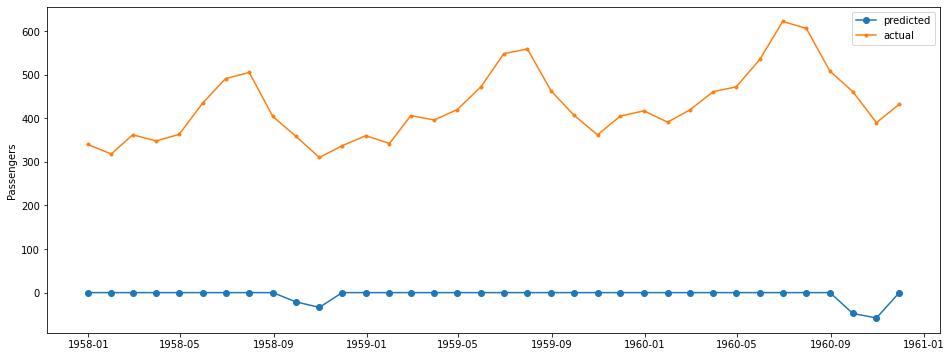

In [28]:
show_result(y_test[:HORIZON], predictions[:HORIZON], "Passengers")